<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Импорты**

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

data = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
datetime = pd.to_datetime(df['datetime'].values)
df['datetime'] = datetime
data['datetime'] = datetime

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
df.set_index('datetime', inplace = True)
data.set_index('datetime', inplace = True)

In [7]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Ресемплирование данных по 1 часу...

In [8]:
df = df.resample('1H').sum()
data = df.resample('1H').sum()

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data = df

## Анализ

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00.

График разброса данных о заказах такси с применением сглаживания временных рядов.

Разброс значений достаточно большой, поэтому использовал количество окон равное 50, чтобы кривая скользящего среднего была похожа на более-менее четкую линнию...

**Тренды и сезонность**

**Месячная сезонность**

Так как нам даны данные только за половину года, у нас нет возможности сказать, что повышение кривой rolling_mean ближе к осени это тренд или сезонность.

Нет возможности понаблюдать за несколькими полными циклами, которые четко отразят нам существующие тренды и сезонности...

In [11]:
df['rolling_mean'] = df.rolling(24).mean()

In [12]:
df.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


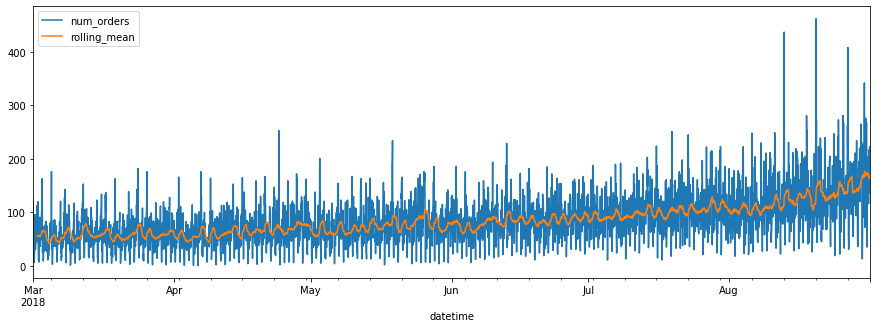

In [13]:
df.plot(figsize=(15, 5))

**Как выглядит ежедневный цикл** - ежедневный цикл

Меньше всего такси вызывают утром, больше всего - днем и ночью

Имеется внутрисуточная сезонность - продажи утром отличаются от продаж вечером

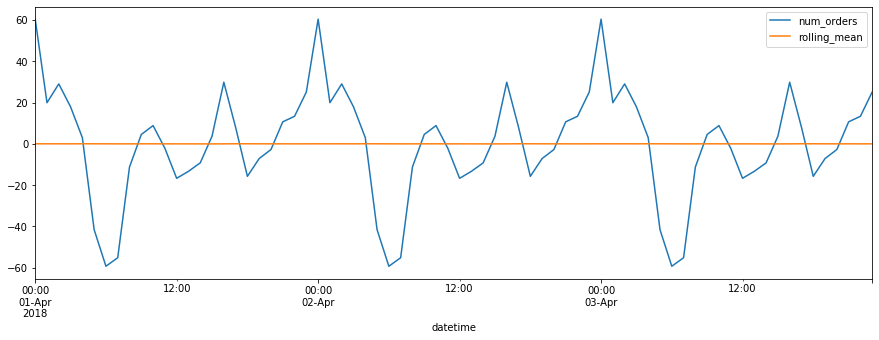

In [14]:
dec_df = df.dropna()

decomposed = seasonal_decompose(dec_df)

decomposed.seasonal['2018-04-01':'2018-04-03'].plot(figsize=(15, 5))

**Как выглядит еженедельный цикл** - дневная сезонность

Нет зависимости от дня недели, дневная сезонность не наблюдается

<Figure size 1440x1440 with 0 Axes>

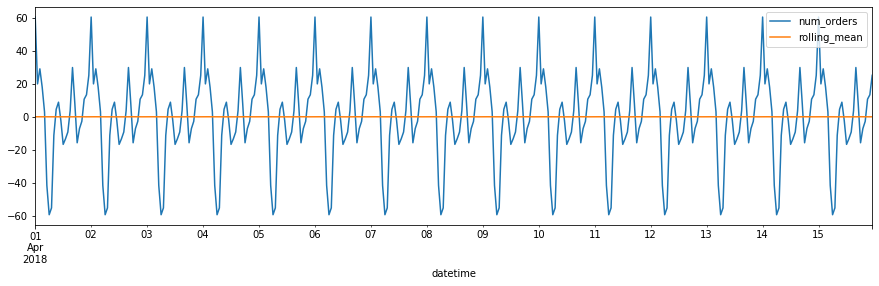

In [15]:
plt.figure(figsize=(20, 20))

decomposed = seasonal_decompose(dec_df)

decomposed.seasonal['2018-04-01':'2018-04-15'].plot(figsize=(15, 4))

**Разности временного ряда**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


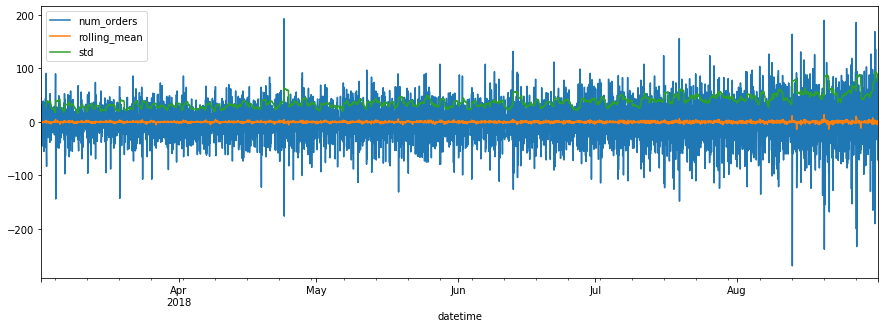

In [16]:
dec_df -= dec_df.shift()
dec_df['std'] = dec_df['num_orders'].rolling(24).std()
dec_df.plot(figsize=(15, 5))

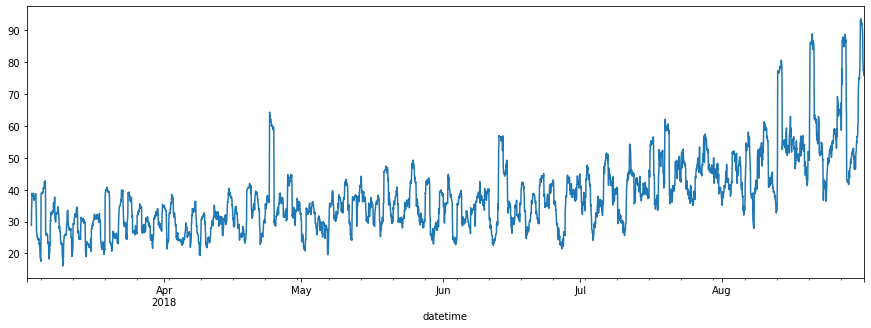

In [17]:
dec_df['std'].plot(figsize=(15, 5))

## Обучение

**Разделение на выборки**

In [18]:
data.sort_index(inplace=True)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print('Проверка, что все адекватно разделилось:\n')
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

Проверка, что все адекватно разделилось:

2018-03-01 23:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [19]:
data = data.drop('rolling_mean', axis=1)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Создание признаков**

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



make_features(data, 2, 24)

In [21]:
#### data.head(10)

In [22]:
#data = data.drop(['year', 'month', 'day', 'dayofweek'], axis = 1)

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [24]:
print('Скаляризация - уравновешивание признаков...')

scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

Скаляризация - уравновешивание признаков...


***Модель линейной регрессии***

In [25]:
model = LinearRegression()

model.fit(features_train, target_train)

predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)

RMSE обучающей выборки: 30.880218112304377
RMSE тестовой выборки:  51.268666988640035


***LGBMRegressor***

In [26]:
model1 = LGBMRegressor(random_state=12345, learning_rate = 0.01)
model1.fit(features_train, target_train)

predictions1_train = model1.predict(features_train)
predictions1_test = model1.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions1_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions1_test)**0.5)

RMSE обучающей выборки: 25.82304999926034
RMSE тестовой выборки:  60.89763592149622


Подбор оптимальных параметров для LGBMRegressor

In [27]:
parametrs = {'learning_rate': [0.01, 0.05, 0.1, 1],
                'n_estimators': range(10, 120, 10)}

In [28]:
scoring = make_scorer(mean_squared_error, greater_is_better=False)

In [29]:
grid = RandomizedSearchCV(model1, parametrs, n_iter = 10, cv=3, scoring = scoring, verbose = 0, random_state = 12345)
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100, 'learning_rate': 0.05}

In [30]:
model1 = LGBMRegressor(random_state=12345, learning_rate = 0.05, n_estimators = 100)
model1.fit(features_train, target_train)

predictions1_train = model1.predict(features_train)
predictions1_test = model1.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions1_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions1_test)**0.5)

RMSE обучающей выборки: 18.63052751649666
RMSE тестовой выборки:  44.91736350888764


## Тестирование

**Результаты по RMSE**

In [31]:
display(pd.DataFrame(np.array([[mean_squared_error(target_train, predictions_train)**0.5,  mean_squared_error(target_test, predictions_test)**0.5],
                           [mean_squared_error(target_train, predictions1_train)**0.5, mean_squared_error(target_test, predictions1_test)**0.5]]),
                    columns = ['RMSE на обучающей выборке', 'RMSE на тестовой выборке'], index = ['LinearRegression', 'LGBMRegressor']))

,RMSE на обучающей выборке,RMSE на тестовой выборке
LinearRegression,30.880218,51.268667
LGBMRegressor,18.630528,44.917364


**Вывод**

Нам необходимо было обучить от 2ух моделей регрессии, с помощью функций или SearchCV подобрать гиперпараметры и довести метрику RMSE до 48-.

Полученные результаты можно наблюдать в таблице выше и на графиках ниже!



***LinearRegression***

In [32]:
df_plot = test
df_plot['Реальные'] = target_test
df_plot = df_plot.drop(['num_orders', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'rolling_mean'], axis = 1)
df_plot['Предсказанные'] = predictions_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


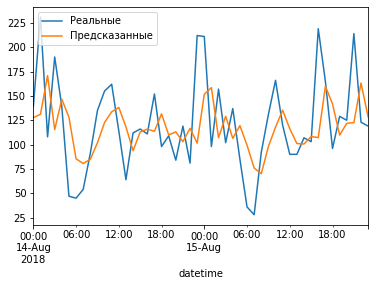

In [33]:
df_plot['2018-08-14':'2018-08-15'].plot()

***LGBMRegressor***

In [34]:
df_plot = test
df_plot['Реальные'] = target_test
df_plot = df_plot.drop(['num_orders', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'rolling_mean'], axis = 1)
df_plot['Предсказанные'] = predictions1_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


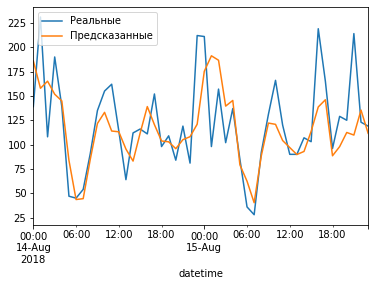

In [35]:
df_plot['2018-08-14':'2018-08-15'].plot()

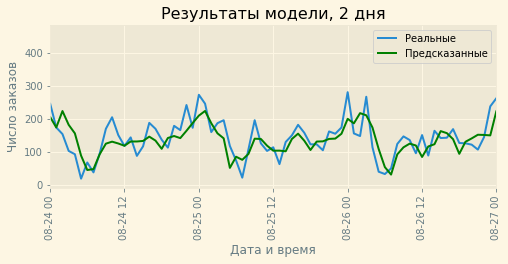

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48